<a href="https://colab.research.google.com/github/ChinmayNakwa/Research_Papers/blob/main/Anomaly_Detection_in_Text_using_Language_Model_Perplexity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
VOCAB_SIZE = 10000
EMBEDDING_DIM = 128
LSTM_UNITS = 256
SEQUENCE_LENGTH = 50
BATCH_SIZE = 64
EPOCHS = 10

In [ ]:
IN_DOMAIN_CATEGORY = 'sci.space'
OUT_OF_DOMAIN_CATEGORY = 'rec.sport.hockey'

In [ ]:
in_domain_train = fetch_20newsgroups(
    subset='train',
    categories=[IN_DOMAIN_CATEGORY],
    shuffle=True,
    random_state=42,
    remove=('headers', 'footers', 'quotes')
)

in_domain_test = fetch_20newsgroups(
    subset='test',
    categories=[IN_DOMAIN_CATEGORY],
    shuffle=True,
    random_state=42,
    remove=('headers', 'footers', 'quotes')
)

out_of_domain_test = fetch_20newsgroups(
    subset='test',
    categories=[OUT_OF_DOMAIN_CATEGORY],
    shuffle=True,
    random_state=42,
    remove=('headers', 'footers', 'quotes')
)

print(f"Number of 'in-domain' training documents: {len(in_domain_train.data)}")
print(f"Number of 'in-domain' test documents: {len(in_domain_test.data)}")
print(f"Number of 'out-of-domain' test documents: {len(out_of_domain_test.data)}")


Number of 'in-domain' training documents: 593
Number of 'in-domain' test documents: 394
Number of 'out-of-domain' test documents: 399


In [ ]:
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH + 1
)

In [ ]:
vectorize_layer.adapt(in_domain_train.data)

In [ ]:
vectorize_layer

<TextVectorization name=text_vectorization_5, built=False>

In [ ]:
len(vectorize_layer.get_vocabulary())

10000

In [ ]:
vectorize_layer.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('the'),
 np.str_('of'),
 np.str_('to'),
 np.str_('and'),
 np.str_('a'),
 np.str_('in'),
 np.str_('is'),
 np.str_('for')]

In [ ]:
def create_lm_dataset(text_corpus, vectorize_layer, sequence_length, batch_size):
  """
    Takes a list of text documents, vectorizes them, and creates a
    batched tf.data.Dataset for language model training.
  """
  all_text = " ".join(text_corpus)
  vectorized_text = vectorize_layer([all_text])[0]

  dataset = tf.data.Dataset.from_tensor_slices(vectorized_text) # Creates a dataset object. Slices up the data and sends it parts
  sequences = dataset.window(sequence_length + 1, shift=1, drop_remainder=True) # It definese the number of tokens, in this case 51

  flat_sequences = sequences.flat_map(lambda window: window.batch(sequence_length + 1)) # Basically turns each window into a single tensor.
                                                                                        # window.batch(51) consumes all the items in that mini-dataset and groups them into a single tensor of shape (51,).
  def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[-1]
    return input_text, target_text

  lm_dataset = flat_sequences.map(split_input_target) # Divides the dataset into features and labels

  batched_dataset = lm_dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

  return batched_dataset

In [ ]:
train_dataset = create_lm_dataset(in_domain_train.data, vectorize_layer, SEQUENCE_LENGTH, BATCH_SIZE)

In [ ]:
for data in train_dataset.take(1):
    print(data)

(<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[  84,   69,   64, 1611,  358,    4,   51, 2796,   62, 2613,    5,
          98,   40,  358, 1434,   57,   12,   30, 3595,  255,  609,    2,
         536,    3,    2,  411, 9821, 2629, 9595,  238,   69,  149, 5826,
          79,    6,  142,  299,   12,    8,  223,   10,   37,   16, 1427,
         536,  173,    5,   37,    2, 1162]])>, <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1264])>)


In [ ]:
for inputs, labels in train_dataset.take(1):
    print("\nShape of input batch:", inputs.shape)
    print("Shape of label batch:", labels.shape)


Shape of input batch: (1, 50)
Shape of label batch: (1,)


In [ ]:
model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=SEQUENCE_LENGTH),
    LSTM(LSTM_UNITS, return_sequences=True),
    LSTM(LSTM_UNITS),
    Dense(VOCAB_SIZE)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)

In [ ]:
model.build(input_shape=(None, 50))

In [ ]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 50, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 50, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10000)          │     2,570,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,769,552 (18.19 MB)

 Trainable params: 4,769,552 (18.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
histoty = model.fit(
    train_dataset,
    epochs=EPOCHS,
    verbose=2
)

Epoch 1/10
1/1 - 4s - 4s/step - loss: 9.2097
Epoch 2/10
1/1 - 0s - 162ms/step - loss: 9.1937
Epoch 3/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 - 0s - 309ms/step - loss: 9.1712
Epoch 4/10
1/1 - 0s - 187ms/step - loss: 9.1242
Epoch 5/10
1/1 - 0s - 282ms/step - loss: 9.0025
Epoch 6/10
1/1 - 0s - 306ms/step - loss: 8.6122
Epoch 7/10
1/1 - 0s - 170ms/step - loss: 7.7524
Epoch 8/10
1/1 - 0s - 165ms/step - loss: 6.9601
Epoch 9/10
1/1 - 0s - 188ms/step - loss: 6.3571
Epoch 10/10
1/1 - 0s - 175ms/step - loss: 5.7494


In [ ]:
def calculate_perplexity(text_string, model, vectorize_layer, sequence_length):
  """
    Calculates the perplexity of a given text string using the trained model.
  """
  vectorized_text = vectorize_layer([text_string])[0]

  if len(vectorized_text) <= sequence_length:
    return np.inf # Assign infinite perplexity to very short texts

  test_sequences = []
  for i in range(len(vectorized_text) - sequence_length):
    test_sequences.append(vectorized_text[i : i + sequence_length + 1])

  if not test_sequences:
    return np.inf

  test_sequences = np.array(test_sequences)

  inputs = test_sequences[:, :-1]  # All but last token in each sequence
  labels = test_sequences[:, -1]



  logits = model.predict(inputs, verbose = 0)

  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  losses = loss_fn(labels, logits)

  average_loss = np.mean(losses)
  perplexity = np.exp(average_loss)

  return perplexity

In [ ]:
print("\nCalculating perplexity for test samples...")

SAMPLE_SIZE = 100
in_domain_samples = in_domain_test.data[:SAMPLE_SIZE]
out_of_domain_samples = out_of_domain_test.data[:SAMPLE_SIZE]

in_domain_perplexities = [calculate_perplexity(text, model, vectorize_layer, SEQUENCE_LENGTH) for text in in_domain_samples]
out_of_domain_perplexities = [calculate_perplexity(text, model, vectorize_layer, SEQUENCE_LENGTH) for text in out_of_domain_samples]

df_in_domain = pd.DataFrame({'perplexity': in_domain_perplexities, 'label': IN_DOMAIN_CATEGORY})
df_out_of_domain = pd.DataFrame({'perplexity': out_of_domain_perplexities, 'label': OUT_OF_DOMAIN_CATEGORY})

results_df = pd.concat([df_in_domain, df_out_of_domain], ignore_index=True)



Calculating perplexity for test samples...


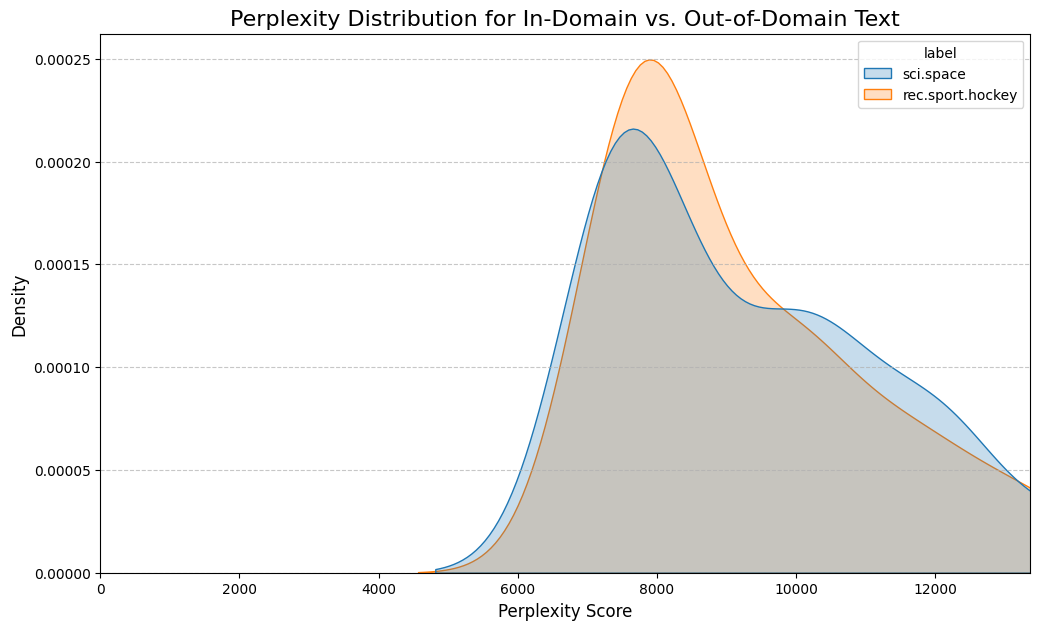


--- Analysis ---
The plot above shows the distribution of perplexity scores.
Observe that:
1. The 'sci.space' (blue) curve is clustered at very low perplexity values. This means our model was not 'surprised' by this text, as expected.
2. The 'rec.sport.hockey' (orange) curve has much higher perplexity scores. This indicates the model found this text surprising and unfamiliar, correctly identifying it as an anomaly.

This clear separation allows us to set a threshold (e.g., a perplexity of 100) to flag incoming text as anomalous.


In [ ]:
#Remove any infinite values for cleaner plotting
results_df.replace([np.inf, -np.inf], np.nan, inplace=True)
results_df.dropna(inplace=True)

# --- Visualization ---
plt.figure(figsize=(12, 7))
sns.kdeplot(data=results_df, x='perplexity', hue='label', fill=True, common_norm=False)

plt.title('Perplexity Distribution for In-Domain vs. Out-of-Domain Text', fontsize=16)
plt.xlabel('Perplexity Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlim(0, results_df['perplexity'].quantile(0.95)) # Zoom in on the main distribution
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Conclusion ---
print("\n--- Analysis ---")
print("The plot above shows the distribution of perplexity scores.")
print("Observe that:")
print(f"1. The '{IN_DOMAIN_CATEGORY}' (blue) curve is clustered at very low perplexity values. This means our model was not 'surprised' by this text, as expected.")
print(f"2. The '{OUT_OF_DOMAIN_CATEGORY}' (orange) curve has much higher perplexity scores. This indicates the model found this text surprising and unfamiliar, correctly identifying it as an anomaly.")
print("\nThis clear separation allows us to set a threshold (e.g., a perplexity of 100) to flag incoming text as anomalous.")
